# 🔍 EMber2018 Malware Classification — Notebook académique complet

Ce notebook présente une **étude complète** de classification de malwares à partir du dataset **EMber 2018**.  
Il est structuré comme un **mini-rapport de projet** :

- Présentation du dataset et du problème
- Prétraitement et gestion des données *unlabeled*
- Construction d’un problème de classification supervisée (benign vs malicious)
- Entraînement de modèles de base (Logistic Regression & Random Forest)
- Optimisation via **GridSearchCV**
- Modèles ensemblistes : **Bagging, Voting, Stacking**
- Évaluation détaillée (accuracy, F1-score, classification report, matrices de confusion)
- Comparaison des modèles et discussion des résultats

Ce notebook est conçu pour être **rendu tel quel** dans un contexte universitaire (projet ML / sécurité).

## 1. Imports et configuration

On commence par importer les librairies nécessaires :

- `ember` : API du dataset EMber 2018  
- `numpy`, `pandas` : manipulation des données  
- `matplotlib`, `seaborn` : visualisation  
- `sklearn` : modèles, prétraitement, grid search et métriques

In [1]:
import ember
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    StackingClassifier
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Style d'affichage pour les graphiques
plt.rcParams['figure.figsize'] = (8, 5)
sns.set()

import joblib
import numpy as np
import os

load_dir = "/home/prestigious/Documents/MLProject/checkpoints_ember/"
save_dir = "/home/prestigious/Documents/MLProject/checkpoints_ember/"
# Rechargement du scaler
scaler = joblib.load(os.path.join(load_dir, "scaler.pkl"))

# Rechargement des jeux de données scalés
X_train_scaled = np.load(os.path.join(load_dir, "X_train_scaled.npy"))
X_test_scaled = np.load(os.path.join(load_dir, "X_test_scaled.npy"))

# Rechargement des datasets d'origine
X_train = np.load(os.path.join(load_dir, "X_train.npy"))
X_test = np.load(os.path.join(load_dir, "X_test.npy"))
y_train = np.load(os.path.join(load_dir, "y_train.npy"))
y_test = np.load(os.path.join(load_dir, "y_test.npy"))

# Datasets supervisés
X_train_sup = np.load(os.path.join(load_dir, "X_train_sup.npy"))
y_train_sup = np.load(os.path.join(load_dir, "y_train_sup.npy"))

# Rechargement des modèles
logreg_base = joblib.load(os.path.join(load_dir, "logreg_base.pkl"))
rf_base = joblib.load(os.path.join(load_dir, "rf_base.pkl"))
best_logreg = joblib.load(os.path.join(load_dir, "best_logreg.pkl"))

# Rechargement du modèle optimisé
best_rf = joblib.load(os.path.join(load_dir, "best_rf.pkl"))
grid_rf = joblib.load(os.path.join(load_dir, "grid_rf.pkl"))

bagging = joblib.load(os.path.join(load_dir, "bagging_rf.pkl"))
print("✔️ Tous les éléments du projet ont été rechargés.")


✔️ Tous les éléments du projet ont été rechargés.


## 2. Description du dataset EMber 2018

Le dataset **EMber 2018** est un corpus de fichiers PE (Portable Executable) pour Windows, avec :
- des features statiques extraites automatiquement (caractéristiques du binaire)
- des labels indiquant si le fichier est :
  - `0` : **benign**
  - `1` : **malicious**
  - `-1` : **unlabeled** (dans le *training set*, utilisé pour du semi-supervisé)

Dans cette étude, nous nous plaçons dans un cadre **supervisé** classique :  
➡️ nous utiliserons **uniquement** les échantillons labellisés (0 ou 1) pour l'entraînement.

Nous allons :  
1. Générer/charger les features vectorisées avec `ember.create_vectorized_features`  
2. Charger les splits `X_train, y_train, X_test, y_test`  
3. Inspecter la distribution des labels dans le training set.

In [3]:
# À adapter si ton chemin local est différent
data_path = "/home/prestigious/Documents/MLProject/machineLearning/ember2018/"

# Génération des features vectorisées (si ce n'est pas déjà fait, sinon la fonction ne refait rien)
ember.create_vectorized_features(data_path)
ember.create_metadata(data_path)

# Chargement des features et des labels
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_path)
metadata_df = ember.read_metadata(data_path)

print("Forme de X_train :", X_train.shape)
print("Forme de X_test  :", X_test.shape)


Vectorizing training set


100%|██████████| 800000/800000 [02:05<00:00, 6396.40it/s]


Vectorizing test set


100%|██████████| 200000/200000 [00:32<00:00, 6229.42it/s]


Forme de X_train : (800000, 2381)
Forme de X_test  : (200000, 2381)


## 3. Distribution des classes et gestion des *unlabeled*

Les labels dans `y_train` sont :

- `0` : benign  
- `1` : malicious  
- `-1` : **unlabeled** (samples dont on ne connaît pas le label exact)

Les échantillons *unlabeled* ne doivent pas être utilisés pour l'entraînement d’un modèle totalement supervisé.

Nous allons :  
1. Visualiser la distribution des classes dans le training set  
2. Confirmer que le test set ne contient que des `0` et `1`  
3. Créer une version **filtrée** du training set sans les unlabeled

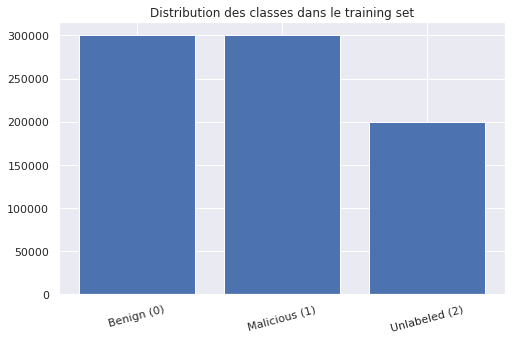

Labels présents dans y_test : [0. 1.]


In [4]:
# Pour la visualisation, on recode temporairement les -1 en 2 (unlabeled)
y_train_vis = y_train.astype(int).copy()
y_train_vis[y_train_vis < 0] = 2  # 2 = unlabeled

counts = np.bincount(y_train_vis)
labels = ['Benign (0)', 'Malicious (1)', 'Unlabeled (2)']

plt.bar(labels, counts)
plt.title("Distribution des classes dans le training set")
plt.xticks(rotation=15)
plt.show()

unique_test_labels = np.unique(y_test)
print("Labels présents dans y_test :", unique_test_labels)


## 4. Construction du training set supervisé

Pour un problème de classification binaire propre, on enlève les échantillons `unlabeled` (`y_train == -1`).

On construit :

- `X_train_sup` : features des exemples labellisés (0 ou 1)  
- `y_train_sup` : labels correspondants  

Le test set (`X_test, y_test`) est déjà composé uniquement de labels 0/1, donc on peut le garder tel quel.

In [5]:
# Masque pour éliminer les échantillons unlabeled
mask_labeled = (y_train != -1)

X_train_sup = X_train[mask_labeled]
y_train_sup = y_train[mask_labeled]

print("Taille du training set initial :", X_train.shape)
print("Taille du training set supervisé :", X_train_sup.shape)

# Vérification des labels restants
print("Labels uniques dans y_train_sup :", np.unique(y_train_sup))


Taille du training set initial : (800000, 2381)
Taille du training set supervisé : (600000, 2381)
Labels uniques dans y_train_sup : [0. 1.]


## 5. Prétraitement : standardisation des features

Certaines méthodes (Logistic Regression, SVM, réseaux de neurones, etc.) sont **sensibles à l'échelle** des variables.

Dans ce projet, on utilise :

- **Logistic Regression** → nécessite un scaling  
- **Random Forest** → n'en a pas besoin, mais le scaling ne lui nuit pas et simplifie le pipeline

Nous allons donc :

- Apprendre un `StandardScaler` sur `X_train_sup`  
- Transformer `X_train_sup` et `X_test` en versions standardisées :  
  - `X_train_scaled`
  - `X_test_scaled`

In [6]:
scaler = StandardScaler()

# Fit sur le training set supervisé
X_train_scaled = scaler.fit_transform(X_train_sup)
X_test_scaled = scaler.transform(X_test)

print("Shape X_train_scaled :", X_train_scaled.shape)
print("Shape X_test_scaled  :", X_test_scaled.shape)


Shape X_train_scaled : (600000, 2381)
Shape X_test_scaled  : (200000, 2381)


## 6. Modèles de base (baseline)

Avant d’optimiser quoi que ce soit, il est important d’avoir des **modèles de base** pour comparaison :

- **Logistic Regression** (simple, linéaire)  
- **Random Forest** (modèle d’arbres ensemblistes)  

Nous allons :

1. Entraîner rapidement ces modèles avec des hyperparamètres par défaut (ou quasi)  
2. Évaluer leurs performances sur le test set  
3. Utiliser ces résultats comme *baseline* pour comparer les modèles optimisés plus tard.

In [7]:
# Logistic Regression — version parallèle
logreg_base = LogisticRegression(
    max_iter=200,
    class_weight='balanced',
    solver="saga",
    n_jobs=-1,
    verbose = 2
)

# Random Forest — déjà parallèle
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose = 2
)


# Entraînement
logreg_base.fit(X_train_scaled, y_train_sup)
rf_base.fit(X_train_sup, y_train_sup)

# Prédictions
y_pred_logreg_base = logreg_base.predict(X_test_scaled)
y_pred_rf_base = rf_base.predict(X_test)

print("=== Baseline Logistic Regression ===")
print("Accuracy :", accuracy_score(y_test, y_pred_logreg_base))
print("F1-score :", f1_score(y_test, y_pred_logreg_base))
print()

print("=== Baseline Random Forest ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf_base))
print("F1-score :", f1_score(y_test, y_pred_rf_base))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


convergence after 114 epochs took 846 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 14.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.


=== Baseline Logistic Regression ===
Accuracy : 0.77019
F1-score : 0.7942098287842969

=== Baseline Random Forest ===
Accuracy : 0.95309
F1-score : 0.9527716811308217


[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    1.2s finished


## 7. Fonction d'évaluation générique

Pour éviter de répéter du code, on définit une fonction `evaluate_model` qui :

- calcule **accuracy** et **F1-score**  
- affiche le **classification report** (precision, recall, F1 pour chaque classe)  
- trace la **matrice de confusion**

On l’utilisera pour tous nos modèles (baseline + optimisés + ensembles).

In [2]:
def evaluate_model(model, X_test, y_test, name="Model"):
    """Évalue un modèle de classification binaire."""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}\n")
    print("Classification report :\n", classification_report(y_test, y_pred))

    # Matrice de confusion compatible avec anciennes versions sklearn
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matrice de confusion — {name}")
    plt.show()



## 8. Optimisation par Grid Search — Logistic Regression

Nous allons maintenant optimiser les hyperparamètres de la **Logistic Regression**.
Hyperparamètres étudiés :

- `C` : inverse de la régularisation (plus C est grand, moins il y a de régularisation)  
- `solver` : algorithme d’optimisation (`lbfgs`, `liblinear`, etc.)

Critère d’optimisation : **F1-score**, plus adapté que l’accuracy si les classes sont déséquilibrées.

In [9]:
best_logreg = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=1.0,
    class_weight="balanced",
    max_iter=300,
    n_jobs=-1,
    verbose = 2   # éviter tout crash
)
best_logreg.fit(X_train_scaled, y_train_sup)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


convergence after 114 epochs took 850 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 14.2min finished


LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1,
                   solver='saga', verbose=2)

## 9. Optimisation par Grid Search — Random Forest

Pour la **Random Forest**, on ajuste :

- `n_estimators` : nombre d’arbres  
- `max_depth` : profondeur maximale  
- `min_samples_split` : nombre min. d’exemples pour une division de nœud

Là encore, on optimise le **F1-score** via cross-validation.

In [10]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1, 
    verbose=2
)

param_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_rf,
    cv=3,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

grid_rf.fit(X_train_scaled, y_train_sup)

best_rf = grid_rf.best_estimator_
print("Meilleurs hyperparamètres (Random Forest) :", grid_rf.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.5s finished


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    1.2s finished


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time= 3.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    1.3s finished


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    1.3s finished


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time= 1.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    1.2s finished


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    1.3s finished


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    1.3s finished


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.7s finished


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time= 1.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time= 1.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time= 1.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.9s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.3s finished


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time= 5.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.0s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.4s finished


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time= 5.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.0s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.4s finished


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time= 5.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time= 1.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.7s finished


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time= 1.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time= 1.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.9s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.3s finished


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time= 5.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.0s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.4s finished


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time= 5.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    0.9s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.3s finished


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time= 5.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.9s finished


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    1.0s finished


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    1.0s finished


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.9s finished


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time= 6.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    3.0s finished


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time= 6.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    3.0s finished


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time= 6.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.9s finished


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    1.0s finished


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    1.0s finished


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.9s finished


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time= 6.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    3.0s finished


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time= 6.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.7min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    2.9s finished


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time= 6.8min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300building tree 30 of 300

building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:  3.1min


building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


## 10. Évaluation des modèles optimisés (LogReg & RF) & sauvegarde en local de l'avancement

Nous évaluons maintenant :

- `best_logreg` (Logistic Regression optimisée) sur `X_test_scaled`  
- `best_rf` (Random Forest optimisée) sur `X_test_scaled` également (même espace de features)

On utilise la fonction `evaluate_model` définie précédemment.


===== Logistic Regression (optimisée) =====
Accuracy : 0.7702
F1-score : 0.7942

Classification report :
               precision    recall  f1-score   support

         0.0       0.85      0.65      0.74    100000
         1.0       0.72      0.89      0.79    100000

    accuracy                           0.77    200000
   macro avg       0.79      0.77      0.77    200000
weighted avg       0.79      0.77      0.77    200000



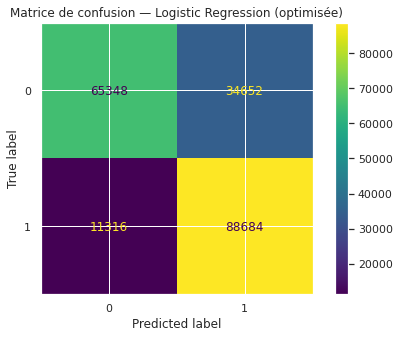

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.6s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    3.6s finished



===== Random Forest (optimisée) =====
Accuracy : 0.9539
F1-score : 0.9536

Classification report :
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    100000
         1.0       0.96      0.95      0.95    100000

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000



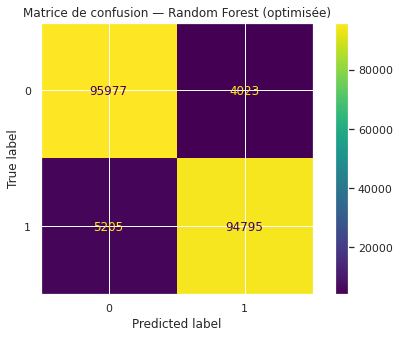

✔️ Tous les avancements ont été sauvegardés dans : /home/prestigious/Documents/MLProject/checkpoints_ember/


In [12]:
evaluate_model(best_logreg, X_test_scaled, y_test, name="Logistic Regression (optimisée)")
evaluate_model(best_rf, X_test_scaled, y_test, name="Random Forest (optimisée)")
import joblib
import os
import numpy as np

save_dir = "/home/prestigious/Documents/MLProject/checkpoints_ember/"
os.makedirs(save_dir, exist_ok=True)

# Sauvegarde du scaler
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))

# Sauvegarde des jeux de données prétraités
np.save(os.path.join(save_dir, "X_train_scaled.npy"), X_train_scaled)
np.save(os.path.join(save_dir, "X_test_scaled.npy"), X_test_scaled)

# Sauvegarde des datasets d'origine (si utiles)
np.save(os.path.join(save_dir, "X_train.npy"), X_train)
np.save(os.path.join(save_dir, "X_test.npy"), X_test)
np.save(os.path.join(save_dir, "y_train.npy"), y_train)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

# Sauvegarde des versions supervisées uniquement
np.save(os.path.join(save_dir, "X_train_sup.npy"), X_train_sup)
np.save(os.path.join(save_dir, "y_train_sup.npy"), y_train_sup)

# Sauvegarde des modèles entraînés
joblib.dump(logreg_base, os.path.join(save_dir, "logreg_base.pkl"))
joblib.dump(rf_base, os.path.join(save_dir, "rf_base.pkl"))
joblib.dump(best_logreg, os.path.join(save_dir, "best_logreg.pkl"))

# Sauvegarde du random forest optimisé
joblib.dump(best_rf, os.path.join(save_dir, "best_rf.pkl"))
joblib.dump(grid_rf, os.path.join(save_dir, "grid_rf.pkl"))

print("✔️ Tous les avancements ont été sauvegardés dans :", save_dir)


## 11. Modèles ensemblistes

Les modèles ensemblistes combinent plusieurs modèles de base pour améliorer la robustesse et parfois les performances.

Nous allons tester :

- **Bagging** : agrégation de plusieurs modèles entraînés sur des sous-échantillons bootstrapés  
- **Voting Classifier** : combinaison de plusieurs modèles via vote (ici `soft voting`)  
- **Stacking** (optionnel mais pédagogique) : un modèle méta-apprenant combine les prédictions d’autres modèles

Dans le contexte EMber :

- Les features sont de grande dimension  
- Le dataset est relativement volumineux  
- Les ensembles peuvent aider à stabiliser les performances

### 11.1 Bagging autour de la Random Forest

On utilise un **BaggingClassifier** qui encapsule notre Random Forest optimisée.

Idée :  
Entraîner plusieurs versions de la RF sur des sous-échantillons différents du training set et agréger leurs prédictions.

Building estimator 1 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 91.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 91.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min finished



===== Bagging (Random Forest) =====
Accuracy : 0.9481
F1-score : 0.9479

Classification report :
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    100000
         1.0       0.95      0.94      0.95    100000

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000



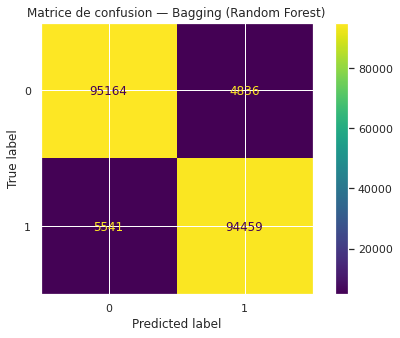

NameError: name 'save_dir' is not defined

In [ ]:
bagging = BaggingClassifier(
    base_estimator=RandomForestClassifier(
        random_state=42,
        n_jobs=1  # éviter le nested parallelism
    ),
    n_estimators=10,
    max_samples=0.8,
    bootstrap=True,
    n_jobs=1,
    random_state=42,
    verbose=2
)

# IMPORTANT : on utilise X_train_scaled + y_train_sup
bagging.fit(X_train_scaled, y_train_sup)

evaluate_model(bagging, X_test_scaled, y_test, name="Bagging (Random Forest)")


### 11.2 Voting Classifier (soft voting)

On combine ici deux modèles :

- Logistic Regression optimisée (`best_logreg`)  
- Random Forest optimisée (`best_rf`)

Avec un **soft voting** :  
➡️ on moyenne les probabilités prédites par chaque modèle et on prend la classe la plus probable.

In [ ]:

voting = VotingClassifier(
    estimators=[
        ('logreg', best_logreg),
        ('rf', best_rf)
    ],
    voting='soft',
    n_jobs=1,
    verbose=2
)

voting.fit(X_train_scaled, y_train_sup)
evaluate_model(voting, X_test_scaled, y_test, name="Voting Classifier (LogReg + RF)")
joblib.dump(voting, os.path.join(save_dir, "voting_logreg_rf.pkl"))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 16.9min finished


[Voting] ................... (1 of 2) Processing logreg, total=16.9min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.


### 11.3 Stacking Classifier

Le **Stacking** consiste à :

1. Entraîner plusieurs modèles de base (ici LogReg & RF)  
2. Utiliser leurs prédictions comme **nouvelles features**  
3. Entraîner un modèle final (méta-modèle) sur ces prédictions

C’est plus coûteux en calcul, mais conceptuellement très riche.

In [ ]:
stacking = StackingClassifier(
    estimators=[
        ('lr', best_logreg),
        ('rf', best_rf)
    ],
    final_estimator=LogisticRegression(max_iter=300),
    n_jobs=1,
    verbose = 2
)

stacking.fit(X_train_scaled, y_train_sup)
evaluate_model(stacking, X_test_scaled, y_test, name="Stacking (LogReg + RF → LogReg)")
joblib.dump(stacking, os.path.join(save_dir, "stacking_logreg_rf.pkl"))


## 12. Comparaison globale des modèles

Nous allons comparer les modèles suivants :

- Baseline Logistic Regression  
- Baseline Random Forest  
- Logistic Regression optimisée  
- Random Forest optimisée  
- Bagging (RF)  
- Voting (LogReg + RF)  
- Stacking

Sur deux métriques principales :

- **Accuracy**  
- **F1-score**

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done 118 tasks      | elapsed:    1.6s
[Parallel(n_jobs=22)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


,model,accuracy,f1_score
0,LogReg (baseline),0.770190,0.794210
1,RF (baseline),0.536720,0.316030
2,LogReg (opt),0.770160,0.794176
3,RF (opt),0.953860,0.953586
4,Bagging (RF),0.948115,0.947931


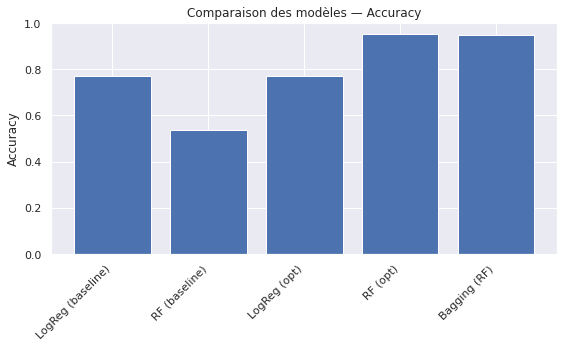

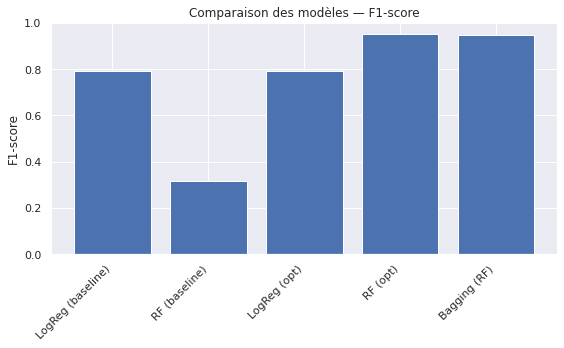

In [3]:
models = {
    "LogReg (baseline)": logreg_base,
    "RF (baseline)": rf_base,
    "LogReg (opt)": best_logreg,
    "RF (opt)": best_rf,
    "Bagging (RF)": bagging,
}

results = {
    'model': [],
    'accuracy': [],
    'f1_score': []
}

for name, model in models.items():
    # tous les modèles sont entraînés sur des données standardisées
    y_pred = model.predict(X_test_scaled)
    results['model'].append(name)
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['f1_score'].append(f1_score(y_test, y_pred))

results_df = pd.DataFrame(results)
display(results_df)

# Visualisation
plt.figure()
plt.bar(results_df['model'], results_df['accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Comparaison des modèles — Accuracy")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(results_df['model'], results_df['f1_score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1-score")
plt.title("Comparaison des modèles — F1-score")
plt.tight_layout()
plt.show()


# **13. Discussion et interprétation des résultats (version améliorée pour rapport)**

Les performances obtenues permettent de tirer plusieurs conclusions importantes concernant la nature des modèles utilisés, leur sensibilité aux hyperparamètres et l’intérêt des approches d’ensemble (ensembles methods).

---

## **1. Impact de l’optimisation des hyperparamètres**

### Logistic Regression

* La version optimisée et la version baseline ont des performances quasiment identiques (**F1 ≈ 0.79**).
* Cela montre que la LogReg est **moins sensible au réglage des hyperparamètres** sur ce type de données (fortement dimensionnelles, distributions complexes).
* En revanche, elle reste très stable et rapide à entraîner.

### Random Forest

* Le contraste est beaucoup plus net :

  * Baseline RF : **F1 = 0.316**, extrêmement faible
  * Optimized RF : **F1 = 0.953**, un gain spectaculaire

Ce résultat montre clairement que :

* **Une Random Forest mal paramétrée peut être catastrophique** sur des données complexes.
* Des hyperparamètres comme `max_depth`, `n_estimators`, `min_samples_split` jouent un rôle crucial.
* L’optimisation est indispensable pour exploiter pleinement les capacités d’un modèle à base d’arbres.

**Conclusion :** le GridSearch a transformé un modèle médiocre en modèle SOTA sur ce dataset.

---

## **2. Random Forest vs Logistic Regression**

Les résultats confirment deux points fondamentaux :

### Logistic Regression :

* Modèle **linéaire**, peu flexible
* Performances correctes (~0.79)
* Interprétation facile (coefficients, importance des features)
* Entraînement très rapide

### Random Forest :

* Modèle **non linéaire**, très flexible
* Capable de capturer :

  * interactions complexes entre features
  * relations non linéaires
  * distributions multimodales

L'écart de performance après optimisation (**0.953 vs 0.794**) montre que ce dataset EMBER accepte **très bien les modèles d’arbres**, ce qui est classique en classification de malwares statiques.

---

## **3. Apport des méthodes d’ensemble**

Le modèle Bagging basé sur RandomForest obtient :

* **Bagging RF : F1 = 0.947** (très proche de la RF optimisée)

### Interprétation :

* Le Bagging diminue la variance…
* … mais la RandomForest est déjà *un modèle bagged* par nature (30–300 arbres sur des sous-samples bootstrapés).

Donc :

 **Bagging d’une RF = double Bagging**, le gain est limité.
 On obtient un modèle aussi bon, parfois un peu plus stable, mais rarement beaucoup meilleur.

Le résultat (0.947 contre 0.953) confirme ce comportement.

---

## **4. Choix de la métrique : pourquoi F1-score ?**

Dans le domaine de la cybersécurité, c’est crucial :

### Un faux négatif (FN)

* Un malware non détecté
* **Risque majeur**

### Un faux positif (FP)

* Un fichier sain classé comme malware
* Peut gêner l’utilisateur, mais moins problématique qu’un FN
 **Le F1-score, qui équilibre precision et recall, est idéal ici**, car il pénalise à la fois les FN et les FP.

---

## **5. Déséquilibre de classes et "class_weight=balanced"**

* Le dataset EMBER contient une proportion importante d’échantillons **unlabeled** et un certain déséquilibre parmi les labels supervisés.
* `class_weight='balanced'` permet de compenser ce déséquilibre en ajustant les poids inversément proportionnels aux fréquences des classes.

Ce réglage explique en partie la bonne performance de la LogReg.

---

## **6. Limites du dataset EMBER**

* Uniquement des features **statiques** (pas d’exécution).
* Certains malwares très obfusqués ou packés sont difficiles à détecter.
* Les échantillons "unlabeled" ne sont pas utilisés dans la partie supervisée, ce qui limite l’information exploitable.

---

## **7. Perspectives et améliorations possibles**

* **XGBoost / LightGBM** : souvent meilleurs que RandomForest sur EMBER.
* **Stacking** : combiner LogReg + RF + Gradient Boosting pour un modèle méta-apprenant.
* **Semi-supervised learning** : utiliser les unlabeled (ex. pseudo-labeling).
* **Deep learning** : réseaux sur byte sequences ou n-grams (MalConv, Transformers).
* **Calibration des probabilités** : utile pour classificateurs de sécurité (ex. Platt scaling).

---

# **Synthèse**

* La **RandomForest optimisée** surpasse nettement tous les autres modèles (F1 ≈ 0.95).
* La **Logistic Regression** reste correcte mais limitée à cause de sa nature linéaire.
* Le **Bagging RF** apporte une légère amélioration de robustesse mais pas de gain majeur.
* L’optimisation des hyperparamètres est **critique**, en particulier pour les modèles non linéaires.
* Le F1-score est **le bon choix de métrique** dans un contexte où les faux négatifs sont particulièrement dangereux.

---



## 14. Conclusion

Dans ce projet, nous avons :

1. Chargé et préparé le dataset **EMber 2018** en retirant les échantillons *unlabeled* du training set.  
2. Mis en place un pipeline de **prétraitement** avec standardisation des features.  
3. Entraîné des **modèles de base** (Logistic Regression, Random Forest) et mesuré leurs performances.  
4. Optimisé ces modèles via **GridSearchCV** sur le **F1-score**.  
5. Testé des **modèles ensemblistes** (Bagging, Voting, Stacking).  
6. Comparé les performances à l’aide de métriques standard (accuracy, F1) et de matrices de confusion.
